## TODO


    scrap for a data:
        - get x_rays images for healthy lungs and with illness
        - prepare labaled directories
        - ~split directiories into: train, val, test sets~
    *NEW* get the data:
        - since getting a nice and useful dataset from scrappin might be too much time consuming
        i will use already prepared kaggle's x_ray dataset
    plot the data:
        - confront healthy lungs with an ill one
    preprocess the data:
        - openCV:
            - what to do with this lib
            - how to preprocess images
            - can we save preprocessed images
            - does it have any data augmenations
            - for data augmentation i will oversample dataset
            - which preprocessing techniques are most viables and why, what does each of them is for
    build a model class:
        - init neural network model:
            - Since its image recognition task i will build CNN
            - build NN
        - perform training:
            1. get prediction
            2. compare it with actuall label
            3. optimize weights (not weights for labels)
            4. log results with proper /*metric*/:
                - which metric should i focus on and what are the main difference
                - As far as training dataset is conserned i will use accuracy since i will oversample that each class (Pneumonia/Normal) will have the same number of sample, but for validation i will use precision/recall to get info how many Positive labels are really true.
        - perform validatiion:
            steps are the same BUT we are not optimizing weights - we dont want to change weights durign validation process
        - callback:
            i want training to stop if it doesnt have any result after aprox ~ 5 epochs
        - logging:
            as mentioned I want to have everything logged:
                - trainingng process
                - validatiion process
                to see wheteher there is overfittin/underfitting
                And i want to have a clear comparison of metrics -> it will be used to determin quality of
                chosen models
    Perform training/validating
    Count how many predictions are ok and how many were wrong:
        - why they were wrong, plot images maybe to justify what they have incommon which influenced the results
    Mby here some statistics comparison for each models?
    
##  AFTER THIS:

    Testing?
    API:
        - i can create an API which will have prob one endpoint which accepts an Image of an x_ray to classify it
        as healthyy or not:
            * uploaded image will be preprocessed!
        - it should work asynchronously!
        - I want have celery workes so app will handle many executions
        - Database would be also nice to store uploaded image -> add it to the training data so it can become bigger
        - cover api with testing
        - cover api with handling such things like:
            - not a x_ray image
            - not a chest_x_ray image
            - bad quality of an image
    Contenerization:
        put everything into a docker
           

In [ ]:
#WEB SCRAPPING

!pip install beautifulsoup4
!pip install requests

In [ ]:
!pip install opencv-python


In [ ]:
!pip install matplotlib

In [ ]:
!pip install Augmentor

In [1]:
import requests
import os
from urllib.request import urlretrieve
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2

import numpy as np

import Augmentor


import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, Compose
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set_style('white')


/home/jakub/miniconda3/envs/x_ray/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#main address to look for images
healthy_chest_url = 'https://www.google.com/search?q=healthy+chest+x+ray+images&tbm=isch&ved=2ahUKEwi2w9u21ov8AhWrk4sKHfa2CqcQ2-cCegQIABAA&oq=healthy+chest+x+ray+images&gs_lcp=CgNpbWcQAzIECCMQJ1C0B1jOCGDKEGgAcAB4AIABSYgB0gGSAQEzmAEAoAEBqgELZ3dzLXdpei1pbWfAAQE&sclient=img&ei=T32jY_bfIKunrgT27aq4Cg&bih=973&biw=1920'
healthy_img_path = './x_ray_images/healthy/'

unhealthy_chest_url = 'https://www.google.com/search?q=unhealthy+chest+x+ray+images&tbm=isch&sxsrf=ALiCzsZI0FcI4kOCdd2popyoRs-A8j7d3w%3A1671658828311&source=hp&biw=1920&bih=973&ei=TH2jY6rrEPKtrgTZ7pr4Ag&iflsig=AJiK0e8AAAAAY6OLXB5j25XmJTsKkC7Kn2ligOJdTDL0&oq=&gs_lcp=CgNpbWcQARgAMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnMgcIIxDqAhAnUABYAGD3B2gBcAB4AIABAIgBAJIBAJgBAKoBC2d3cy13aXotaW1nsAEK&sclient=img'
unhealthy_img_path = './x_ray_images/unhealthy/'



In [ ]:
#Create a function to webscrap google images to get x_rays of chest
def get_images(url: str, path: str):
    #get the url content
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    #get content with "img" and from these get source links
    get_all_tags = soup.find_all("img")
    links = [tag.get("src") for tag in get_all_tags]
    #create dir for images (healthy/unhealthy)
    if not os.path.exists(path):
        os.makedirs(path)
    #download images from given links
    for i, link in enumerate(links):
        try:
            urlretrieve(link, f'{path}/image no.{i}.jpg')
        except ValueError:
            continue  
    

In [ ]:
#download healthy and unhealthy samples of x_ray_chest images
get_images(healthy_chest_url, healthy_img_path)
get_images(unhealthy_chest_url, unhealthy_img_path)

In [ ]:
#plot those images to see whether samples could be good for training

def plot_images_from_dir(path: str):
    #get list of the directories content
    file_names = os.listdir(path)
    n_rows,n_cols = 4, 5
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
    for ax, name in zip(axs.flat,file_names):
        img = mpimg.imread(os.path.join(path, name))
        ax.imshow(img)
        ax.set_title(name)
        ax.axis('off')
    plt.show()
    

In [ ]:
plot_images_from_dir(healthy_img_path)

In [ ]:
plot_images_from_dir(unhealthy_img_path)

It appears that many images are not good samples for training (there are unhealthy lungs in healthy directory). 
I suppose it will be hard to get nice dataset from scrapping so lets keep samples that looks good for further testing (from the API user point of view)but for the model training I will use one of Kaggle's datasets. Dataset is already splited into train, val and test directories which has 2 folders NORMAL and PNEUMONIA


In [ ]:
#investigate into dataset to show if there are any imbalances in the number of samples for each class
val = []      # list of quantity of samples for each class in each dataset
labels = ["NORMAL", "PNEUMONIA"]
for i in os.listdir('./chest_xray/'):
    tmp_val = []
    for label in labels:
        tmp = len(os.listdir(os.path.join(f'./chest_xray/{i}',label)))
        tmp_val.append(tmp)
    val.append(tmp_val)

fig, axs = plt.subplots(1,3, figsize=(12,5))
for ax, value, name in zip(axs, val, os.listdir('./chest_xray/')):
    colors = ['#1f77b4', '#ff7f0e']
    

    # Plot the bars
    sns.barplot(x=labels, y=value, palette=colors, ax=ax, width=0.5)

    # Add a title to the plot
    ax.set_title(f'Patient Diagnoses {name}')

    # Add a label to the y-axis
    ax.set_ylabel('Number of Patients')
    ax.set_xticklabels(labels, rotation=45)


    # Show the plot
plt.show()

As u can see classes of the datasets are imbalanced. In order to balance them i will oversample normal one. Additionaly in validation set there are only 16 images which is really low. My idea is to oversample training dataset, oversample validation set, combine them together and then split into 80-20/ 90-10 train/val set


In [ ]:
train_normal_pic = './chest_xray/train/NORMAL/'
train_pneumonia_pic = './chest_xray/train/PNEUMONIA/'
test_normal_pic = './chest_xray/test/NORMAL/'
test_pneumonia_pic = './chest_xray/test/PNEUMONIA/'
val_normal_pic = './chest_xray/val/NORMAL/'
val_pneumonia_pic = './chest_xray/val/PNEUMONIA/'
all_dir = [train_normal_pic, train_pneumonia_pic, test_normal_pic, test_pneumonia_pic,
             val_normal_pic, val_pneumonia_pic]
for dirc in all_dir:
    print(dirc)
normal_pic = os.listdir(all_dir[0])
pneumonia_pic = os.listdir(all_dir[1])
print(normal_pic[0])

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = mpimg.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}')
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy no.{i+1}')
        ax.axis('off')
    else:
        img = mpimg.imread(f'./chest_xray/train/PNEUMONIA//{pneumonia_pic[i]}')
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia no.{i-3}')
        ax.axis('off')
        
    
        
                   
    

Since some images of pneumonia are really rough to see by an eye I will experiment with some image preprocessing techniques in order to achieve better quality of the dataset

In [ ]:
base_image = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[0]}', cv2.IMREAD_UNCHANGED)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(base_image, cmap='gray')
ax[0].axis('off')

#Gausian blur to compare it with original image to increase sharpness of the image
blure_img = cv2.GaussianBlur(base_image, (9, 9), 3.0)
image_sharp = cv2.addWeighted(base_image, 0.75, blure_img, 0.5, 0)
ax[1].imshow(image_sharp, cmap='gray')
plt.show()


In [ ]:
#Noise removal with gauss kernel
image = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[0]}', cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(2, 3, figsize=(15,5))
image_smoothed_1 = cv2.GaussianBlur(image, (1, 1), 1.0)
image_smoothed_2 = cv2.GaussianBlur(image, (5, 5), 2.0)
image_smoothed_3 = cv2.GaussianBlur(image, (7, 7), 7.0)
image_smoothed_4 = cv2.GaussianBlur(image, (9, 9), 4.0)
image_smoothed_5 = cv2.GaussianBlur(image, (11,11), 5.0)
images = [image, image_smoothed_1, image_smoothed_2, image_smoothed_3,
         image_smoothed_4,image_smoothed_5]
titles = ['Original image','Kernel size: 3x3, std dev: 3.0','Kernel size: 5x5, std dev: 2.0',
          'Kernel size: 7x7, std dev: 3.0','Kernel size: 9x9, std dev: 4.0','Kernel size: 11x11, std dev: 5.0']
for axs, title, img in zip(ax.flat, titles, images):
    axs.imshow(img, cmap='gray')
    axs.set_title(title)
    axs.axis('off')

plt.show()

In [ ]:
#Transform images into binary ones
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 50, 100, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy to binary no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(img, 50, 100, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia to binary no.{i-3}')
        ax.axis('off')

In [ ]:
#erosion
fig, ax = plt.subplots(2,4, figsize=(10,5))
kernel = np.ones((11,11), np.uint8)
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.erode(img, kernel,iterations=1)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy eroded no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.erode(img, kernel,iterations=1)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia eroded no.{i-3}')
        ax.axis('off')

In [ ]:
#dilation
fig, ax = plt.subplots(2,4, figsize=(10,5))
kernel = np.ones((9,9), np.uint8)
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.dilate(img, kernel,iterations=3)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy dilated no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        img = cv2.dilate(img, kernel,iterations=3)

        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia dilated no.{i-3}')
        ax.axis('off')

In [ ]:
#try to draw contours on binary images
fig, ax = plt.subplots(2,4, figsize=(10,5))
for i, ax in zip(range(8), ax.flat):
    if i < 4:
        image = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (0,255,0), 3)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Healthy to binary no.{i+1}')
        ax.axis('off')
    else:
        img = cv2.imread(f'./chest_xray/train/PNEUMONIA/{pneumonia_pic[i]}', cv2.IMREAD_GRAYSCALE)
        _, img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (0,255,0), 3)
        ax.imshow(img, cmap='gray')
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pneumonia to binary no.{i-3}')
        ax.axis('off')

In [ ]:
#Normalization n standarization 
fig, ax = plt.subplots(1,3, figsize=(10,5))
img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[0]}')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
standardized = (gray_img - np.mean(gray_img)) / np.std(gray_img)
normalized = (standardized - np.min(standardized)) / (np.max(standardized) - np.min(standardized))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(standardized, cmap='gray')
ax[1].set_title('Standarized image')
ax[2].imshow(normalized, cmap='gray')
ax[2].set_title('Standarized and normalized image')
plt.show()
    

In [ ]:
def preprocess_image(img_path: str):
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    erosion_kernel = np.ones((9,9), np.uint8)
#     standardized = (gray_img - np.mean(gray_img)) / np.std(gray_img)
#     normalized = (standardized - np.min(standardized)) / (np.max(standardized) - np.min(standardized))
    blure_img = cv2.GaussianBlur(gray_img, (3, 3), 3.0)
    image_sharp = cv2.addWeighted(gray_img, 0.75, blure_img, 0.75, 0)
    eroded = cv2.erode(image_sharp, erosion_kernel,iterations=1)
#     img_resized = cv2.resize(eroded, (640,420))
    return eroded

In [ ]:
# Compare original image with an image fully preprocessed (normalization, stadarization, erosion, increased_sharpness)
img = cv2.imread(f'./chest_xray/train/NORMAL/{normal_pic[0]}')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
erosion_kernel = np.ones((9,9), np.uint8)
standardized = (gray_img - np.mean(gray_img)) / np.std(gray_img)
normalized = (standardized - np.min(standardized)) / (np.max(standardized) - np.min(standardized))
blure_img = cv2.GaussianBlur(normalized, (3, 3), 3.0)
image_sharp = cv2.addWeighted(normalized, 0.75, blure_img, 0.5, 0)
eroded = cv2.erode(image_sharp, erosion_kernel,iterations=1)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')
ax[1].imshow(eroded, cmap='gray')
ax[1].set_title('Fully preprocessed image')
ax[1].axis('off')
plt.show()




In [2]:
#New directories for preprocessed images
paths = ['./chest_xray_prep/train/NORMAL/','./chest_xray_prep/train/PNEUMONIA/',
         './chest_xray_prep/test/NORMAL/','./chest_xray_prep/test/PNEUMONIA/',
         './chest_xray_prep/val/NORMAL/', './chest_xray_prep/val/NORMAL/']
norm_paths = ['./chest_xray/train/NORMAL/','./chest_xray/train/PNEUMONIA/']
val_paths = ['./chest_xray/val/NORMAL/','./chest_xray/val/PNEUMONIA/']
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

To correctly save images I would have to extend the value of pixels which will colide with normalization and standardization techniques. To break this issue I will not normalize/standardize image during 1st preprocess step. I will do it while loading input to the models. To sum up data pipeline will look like this:
    1. Preproces image applying gausian blur (which helps up with the img sharpness) and erosion
    2. Augment image to perform oversampling to make each class equal with the quantity of samples
    3. Split images into batches
    4. Resize, standardize and normalize each image while puting it into a model

In [ ]:
#Save preprocessed images to the new directories
fig, ax = plt.subplots(1, 2, figsize=(10,10))
for directory, path in zip(all_dir, paths):
    for i, picture in enumerate(os.listdir(directory)):
        prep = preprocess_image(os.path.join(directory, picture))
#         ax[0].imshow(prep, cmap='gray')
#         print(prep.dtype)
        cv2.imwrite(f'{path}{i}.png', prep)
#         example = cv2.imread(f'{path}{i}.png')
#         print(example.dtype)
#         ax[1].imshow(example)
        
#         break
        
    
    
    
    

Unfortunatelly there are many samples which are not readable after this preprocessing, so not to overload the model. Lets focus now on data augmentation to oversample classes and while loading data in DataLoader images will be resized, normalized and standardized. If the results will be not sattisfing. More img preprocessing techniques will be applied

In [ ]:
for path in paths[:2]:
    print(path, len(os.listdir(path)))

In [ ]:
#Oversample training data with augmentation
for path in tqdm(norm_paths):    
    p = Augmentor.Pipeline(f'{path}')
    p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.8)
    p.random_distortion(probability=0.8, grid_width=12, grid_height=12, magnitude=4)
    p.shear(probability=0.8, max_shear_left=15, max_shear_right=15)
    p.sample(4500, multi_threaded=True)
    

In [ ]:
#Oversample validation data with augmentations
for path in tqdm(val_paths):    
    p = Augmentor.Pipeline(f'{path}')
    p.rotate(probability=0.8, max_left_rotation=15, max_right_rotation=15)
    p.flip_left_right(probability=0.8)
    p.random_distortion(probability=0.8, grid_width=12, grid_height=12, magnitude=4)
    p.shear(probability=0.8, max_shear_left=15, max_shear_right=15)
    p.sample(64, multi_threaded=True)

In [ ]:
#remove old images, put images from the augmentions output into the label dir and then remove the output dir itself
# Delete all images in the root folder
for path in val_paths:
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            os.remove(f'{path}/{file}')

    # Copy the contents of the output folder to the root folder
    for file in os.listdir(f'{path}/output'):
        os.rename(f'{path}/output/{file}', f'{path}/{file}')



In [ ]:
# Remove the output folder
for path in val_paths:
    os.rmdir(f'{path}/output')

In [ ]:
for path in norm_paths:
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            os.remove(f'{path}/{file}')

    # Copy the contents of the output folder to the root folder
    for file in os.listdir(f'{path}/output'):
        os.rename(f'{path}/output/{file}', f'{path}/{file}')

In [ ]:
for path in norm_paths:
    os.rmdir(f'{path}/output')

In [ ]:
#4500 norm, 64 val -> we need to move 400 images from norm to val, shuffle all and datasets will be ready
for norm_path, val_path in zip(norm_paths, val_paths):
    for file in os.listdir(val_path)[:4101]:
        os.rename(f'{val_path}/{file}', f'{norm_path}/{file}')


In [ ]:
for path in norm_paths:
    print(path, len(os.listdir(path)))
for path in val_paths:
    print(path, len(os.listdir(path)))

Data is preprocessed - time to build model

In [3]:
#Hyperparams

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 128
MEAN = [0.5]
STD = [0.5]
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 16
TRAIN_DIR = './chest_xray/train/'
VAL_DIR = './chest_xray/val/'
TEST_DIR = './chest_xray/test/'
MODEL_PATH = 'best-model.pt'
SECOND_MODEL_PATH = 'second-model.pt'
THIRD_MODEL_PATH = 'third-model.pt'


In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [5]:
def standarization(image: torch.tensor):
    image -= image.mean()
    image /= image.std()
    return image


In [6]:
train_img_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                     transforms.Grayscale(),
                                      transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(15), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=MEAN, std=STD),
                                     standarization,
                                            ])
val_img_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                     transforms.Grayscale(),

                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=MEAN, std=STD),
                                     standarization,
                                            ])


In [7]:
class EarlyStoppingCallback:
    def __init__(self, patience=9):
        
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False
        
    
    def __call__(self, model, epoch, result):
        val_loss = result['val_loss']
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), THIRD_MODEL_PATH)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

In [8]:
class GPUloader:
    """Wrapper for the dataloader class to automatically move data to chosen device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)
    def __len__(self):
        return len(self.batch)
    

In [9]:
def create_dataloader(dir_path: str, batch_size: int, transforms, device):
    """Create dataloader and automaticaly move data to chosen device"""
    dataset = ImageFolder(dir_path, transform=transforms)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                            num_workers=os.cpu_count(), 
                            pin_memory=True if DEVICE == "cuda" else False )
    loader = GPUloader(loader, device)
    return loader


In [10]:
train_loader = create_dataloader(dir_path=TRAIN_DIR, batch_size=TRAIN_BATCH_SIZE, 
                                 transforms=train_img_transforms, device=DEVICE)
val_loader = create_dataloader(dir_path=VAL_DIR, batch_size=VAL_BATCH_SIZE, 
                               transforms=val_img_transforms, device=DEVICE)


In [11]:
def accuracy(output: torch.tensor, label: torch.tensor):
    """Compute accuracy of correct predictions"""
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == label).item() / len(preds))


In [12]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD,early_stop=EarlyStoppingCallback()):
    """Training and evaluation loops"""    
    optimizer = opt_func(model.parameters(), lr)
    history = []
    for epoch in range(epochs):
        
        model.train()  # Training phase
        train_loss = []       
        for batch in train_loader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # val phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        early_stop(model, epoch, result)
        if early_stop.stop:
            print(f"Training finished after: {epoch} epoch")
            break

    return history


In [13]:

def evaluate(model, val_loader):
    """Validate model performance and return collected metrics"""
    model.eval() #nn.module property to set the model into a evaluation mode
    with torch.no_grad():
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)


In [14]:
class GeneralSteps(nn.Module):
    
    """Class with general steps that are being made while training/validating model. 
    It will be useful while different models so there is no need to copy this step in every model class"""
    
  
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels) 
        return loss
        
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        
        


In [15]:
class X_rayClassification(GeneralSteps):
    """First model will include custom architecture of CNN and linear NN"""
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.ReLU(),
            nn.Conv2d(12, 48, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #size after 1st layer: 48 x IMG_SIZE / 2 x IMG_SIZE / 2

            nn.Conv2d(48, 128, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            #size after 2nd layer: 128 x IMG_SIZE / 4 x IMG_SIZE / 4

            nn.Conv2d(128, 256, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #size after 3rd layer: 256 x IMG_SIZE / 8 x IMG_SIZE / 8
            

            nn.Flatten(), 
            nn.Linear(256*16*16, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
        
    def forward(self, xb):
        return self.network(xb)
 

In [16]:
#create an instance of model's class
model = X_rayClassification()


In [16]:
model1 = X_rayClassification()

In [17]:
to_device(model1, DEVICE)

X_rayClassification(
  (network): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=2048, bias=True)
    (17): ReLU()
    (18): Linear(in

In [17]:
#move model to GPU
to_device(model, DEVICE)

X_rayClassification(
  (network): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=2048, bias=True)
    (17): ReLU()
    (18): Linear(in

In [20]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001

In [19]:
history_model_1 = fit(epochs=num_epochs, model=model, lr=lr, train_loader=train_loader, 
                      val_loader=val_loader, opt_func=opt_func)

Epoch [0], val_loss: 0.3108, val_acc: 0.8873
Epoch [1], val_loss: 0.2723, val_acc: 0.9050
Epoch [2], val_loss: 0.3067, val_acc: 0.8802
Epoch [3], val_loss: 0.2341, val_acc: 0.9127
Epoch [4], val_loss: 0.2116, val_acc: 0.9210
Epoch [5], val_loss: 0.1734, val_acc: 0.9363
Epoch [6], val_loss: 0.1887, val_acc: 0.9255
Epoch [7], val_loss: 0.1811, val_acc: 0.9300
Epoch [8], val_loss: 0.1912, val_acc: 0.9267
Epoch [9], val_loss: 0.1548, val_acc: 0.9407
Epoch [10], val_loss: 0.1762, val_acc: 0.9296
Epoch [11], val_loss: 0.1673, val_acc: 0.9309
Epoch [12], val_loss: 0.1543, val_acc: 0.9418
Epoch [13], val_loss: 0.1478, val_acc: 0.9397
Epoch [14], val_loss: 0.1365, val_acc: 0.9470
Epoch [15], val_loss: 0.1583, val_acc: 0.9429
Epoch [16], val_loss: 0.1549, val_acc: 0.9449
Epoch [17], val_loss: 0.1453, val_acc: 0.9472
Epoch [18], val_loss: 0.1489, val_acc: 0.9478
Epoch [19], val_loss: 0.1215, val_acc: 0.9470
Epoch [20], val_loss: 0.1716, val_acc: 0.9341
Epoch [21], val_loss: 0.1104, val_acc: 0.956

In [20]:
train = [x['train_loss'] for x in history_model_1]
val = [x['val_loss'] for x in history_model_1]
acc = [x['val_acc'] for x in history_model_1]

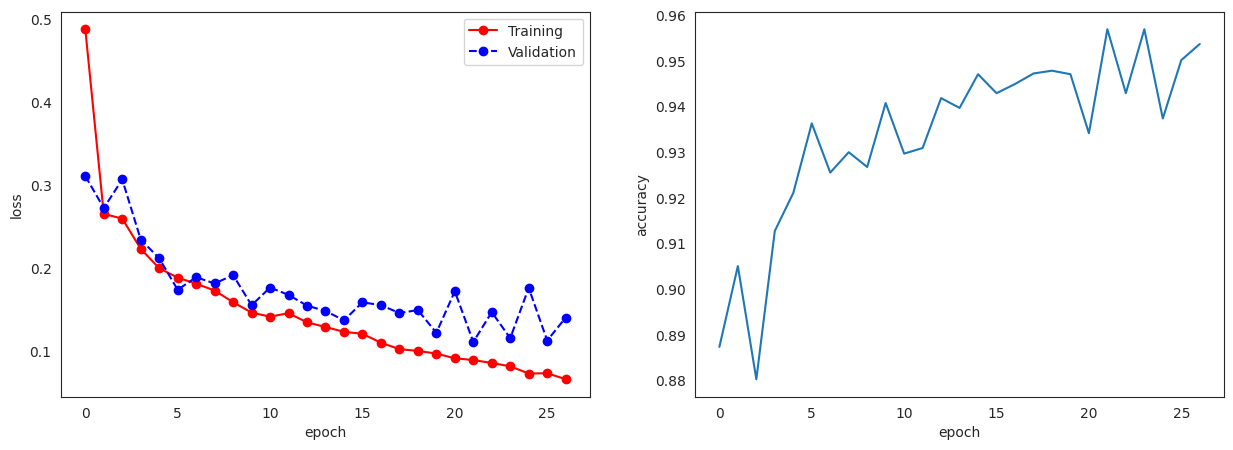

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))

ax[0].plot(train, '-ro')
ax[0].plot(val, '--bo')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(['Training', 'Validation'])
ax[1].plot(acc)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
plt.show()

As we can see the model is good but it starts overfitting around 17 epoch. Lets try out a new model with batchnomalization, dropout 

In [16]:
class ModelDropoutNorm(GeneralSteps):
    """Adding batch_normalization and dropout to previous model to see how it influences the training"""
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, padding=1, padding_mode="zeros"),
            
            nn.ReLU(),
            
            nn.Conv2d(12, 48, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(48, 128, kernel_size=3, padding=1, padding_mode="zeros"),
            
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, padding_mode="zeros"),
            
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, padding_mode="zeros"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(), 
            nn.Linear(256*16*16, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [17]:
model2 = ModelDropoutNorm()

In [17]:
model3 = ModelDropoutNorm()

In [18]:
to_device(model2, DEVICE)

ModelDropoutNorm(
  (network): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [18]:
to_device(model3, DEVICE)

ModelDropoutNorm(
  (network): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [19]:
history_model_2 = fit(epochs=num_epochs, model=model2, lr=lr, train_loader=train_loader, 
                      val_loader=val_loader, opt_func=opt_func)

Epoch [0], val_loss: 0.4489, val_acc: 0.7871
Epoch [1], val_loss: 0.3246, val_acc: 0.8679
Epoch [2], val_loss: 0.2612, val_acc: 0.9007
Epoch [3], val_loss: 0.2936, val_acc: 0.8822
Epoch [4], val_loss: 0.2680, val_acc: 0.8856
Epoch [5], val_loss: 0.2428, val_acc: 0.9224
Epoch [6], val_loss: 0.2090, val_acc: 0.9255
Epoch [7], val_loss: 0.2165, val_acc: 0.9223
Epoch [8], val_loss: 0.2022, val_acc: 0.9207
Epoch [9], val_loss: 0.1888, val_acc: 0.9275
Epoch [10], val_loss: 0.1769, val_acc: 0.9341
Epoch [11], val_loss: 0.2481, val_acc: 0.9179
Epoch [12], val_loss: 0.1876, val_acc: 0.9372
Epoch [13], val_loss: 0.1833, val_acc: 0.9404
Epoch [14], val_loss: 0.1731, val_acc: 0.9429
Epoch [15], val_loss: 0.1691, val_acc: 0.9407
Epoch [16], val_loss: 0.1582, val_acc: 0.9427
Epoch [17], val_loss: 0.1742, val_acc: 0.9352
Epoch [18], val_loss: 0.2278, val_acc: 0.9307
Epoch [19], val_loss: 0.1308, val_acc: 0.9504
Epoch [20], val_loss: 0.1596, val_acc: 0.9469
Epoch [21], val_loss: 0.1427, val_acc: 0.942

In [20]:
train = [x['train_loss'] for x in history_model_2]
val = [x['val_loss'] for x in history_model_2]
acc = [x['val_acc'] for x in history_model_2]

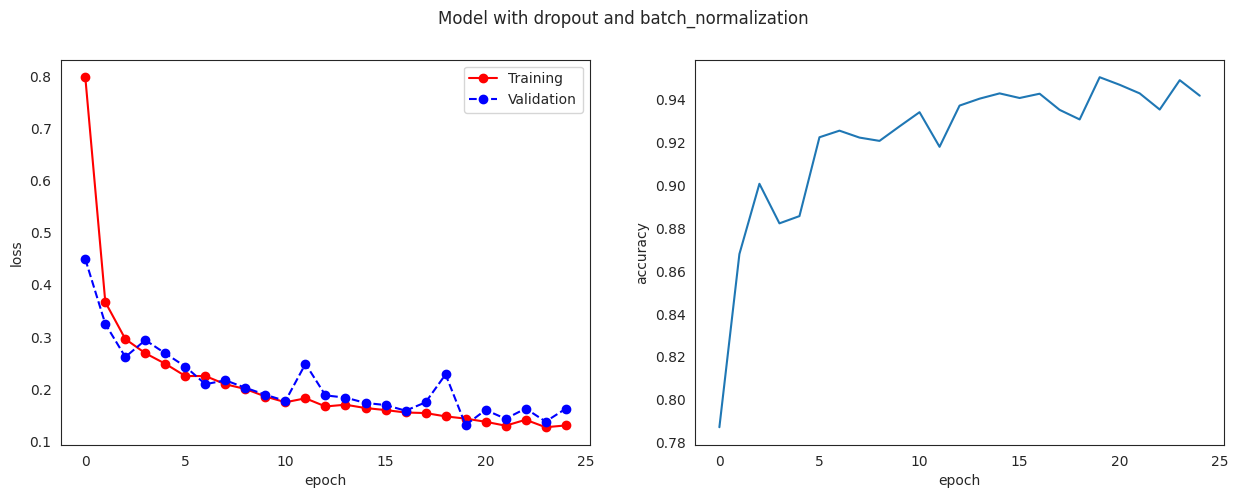

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plt.suptitle("Model with dropout and batch_normalization")
ax[0].plot(train, '-ro')
ax[0].plot(val, '--bo')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(['Training', 'Validation'])
ax[1].plot(acc)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
plt.show()

Check model on testing set

In [26]:
test_dataloader = create_dataloader(TEST_DIR, batch_size=VAL_BATCH_SIZE, transforms=val_img_transforms, 
                                   device=DEVICE)

In [21]:
history_model_3 = fit(epochs=num_epochs, model=model3, lr=lr, train_loader=train_loader, 
                      val_loader=val_loader, opt_func=opt_func)

Epoch [0], val_loss: 0.3858, val_acc: 0.8716
Epoch [1], val_loss: 0.3086, val_acc: 0.8910
Epoch [2], val_loss: 0.3324, val_acc: 0.8575
Epoch [3], val_loss: 0.2930, val_acc: 0.8919
Epoch [4], val_loss: 0.3726, val_acc: 0.8156
Epoch [5], val_loss: 0.3023, val_acc: 0.8585
Epoch [6], val_loss: 0.2565, val_acc: 0.9136
Epoch [7], val_loss: 0.2880, val_acc: 0.9289
Epoch [8], val_loss: 0.2463, val_acc: 0.9078
Epoch [9], val_loss: 0.2332, val_acc: 0.9190
Epoch [10], val_loss: 0.2565, val_acc: 0.9256
Epoch [11], val_loss: 0.2232, val_acc: 0.9158
Epoch [12], val_loss: 0.2345, val_acc: 0.9300
Epoch [13], val_loss: 0.1820, val_acc: 0.9264
Epoch [14], val_loss: 0.1885, val_acc: 0.9375
Epoch [15], val_loss: 0.1881, val_acc: 0.9255
Epoch [16], val_loss: 0.2203, val_acc: 0.9201
Epoch [17], val_loss: 0.2081, val_acc: 0.9221
Epoch [18], val_loss: 0.1815, val_acc: 0.9273
Epoch [19], val_loss: 0.2117, val_acc: 0.9166
Epoch [20], val_loss: 0.2615, val_acc: 0.9039
Epoch [21], val_loss: 0.1629, val_acc: 0.941

In [22]:
train_3 = [x['train_loss'] for x in history_model_3]
val_3 = [x['val_loss'] for x in history_model_3]
acc_3 = [x['val_acc'] for x in history_model_3]

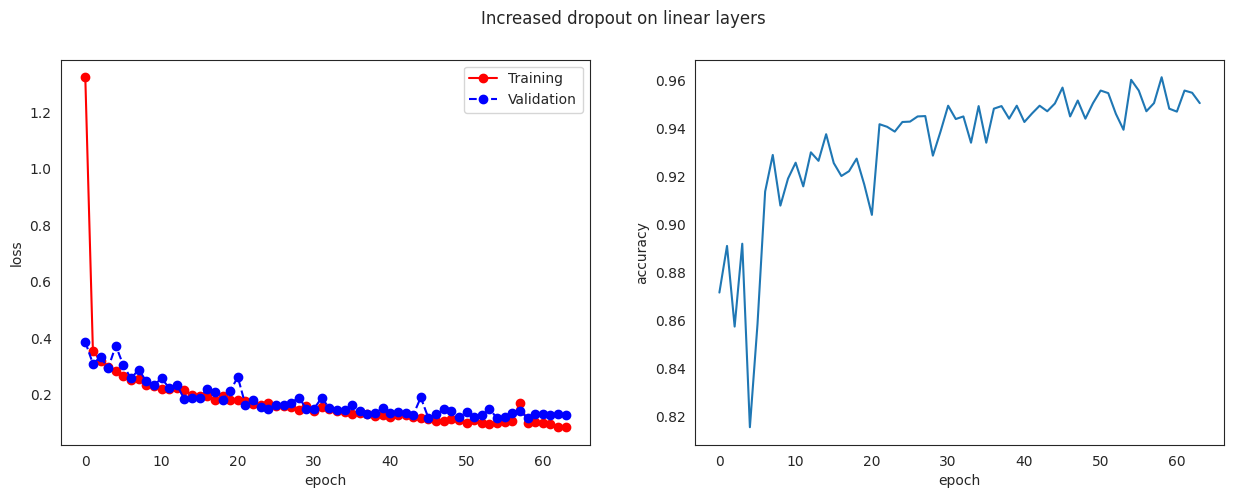

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plt.suptitle("Increased dropout on linear layers")
ax[0].plot(train_3, '-ro')
ax[0].plot(val_3, '--bo')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend(['Training', 'Validation'])
ax[1].plot(acc_3)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
plt.show()

Results for the 3rd model are the best: loss aprox 0.12, acc aprox 95%. This will be base for creating an app